# PINN

In [1]:
# matファイルの読み込み
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 厳密解の可視化

In [3]:
file_path = "./burgers_shock.mat"
exact_data = loadmat(file_path)

In [4]:
x_exact = exact_data["x"]
t_exact = exact_data["t"]
u_exact = exact_data["usol"]

In [5]:
X, T = np.meshgrid(x_exact, t_exact, indexing="ij")

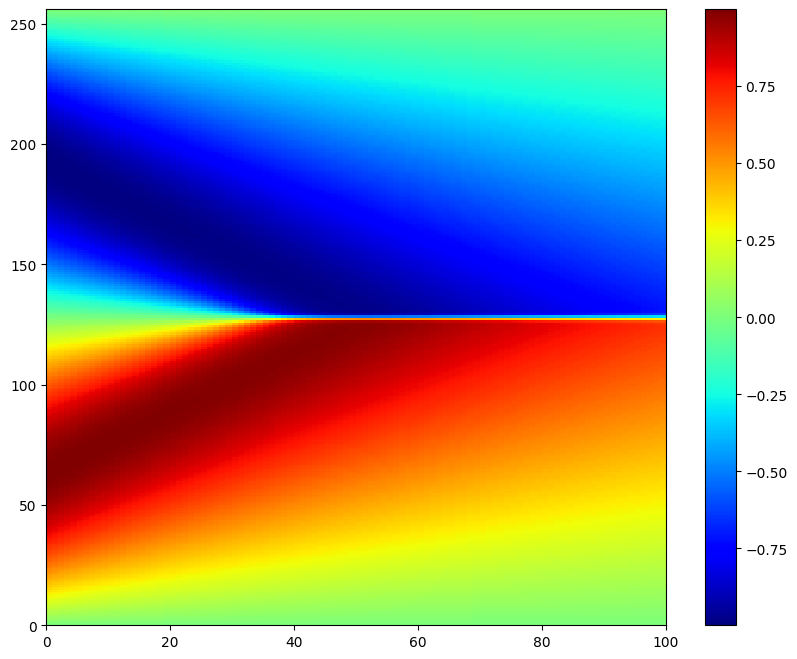

In [6]:
# データの可視化：ヒートマップ
plt.figure(figsize=(10, 8))
plt.pcolor(u_exact, cmap="jet")
plt.colorbar()
plt.show()

## 実装

1. 解きたい方程式（Burers方程式）から損失関数を構成

    $ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = v \frac{\partial^2 u}{\partial x^2} $

In [7]:
criteria = nn.MSELoss() # 損失関数

In [20]:
def physics_informed_loss(x, t, net):
    u = net(x, t)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True, allow_unused=True)[0] # 空間に関する偏微分
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True, allow_unused=True)[0] # 空間に関する偏微分
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True, allow_unused=True)[0] # 時間に関する偏微分
    f = u_t + u * u_x - (0.01 / np.pi) * u_xx
    zeros = torch.zeros(f.size()).to(device)
    return criteria(f, zeros) # 損失関数

2. 初期条件と境界条件から損失関数を構成

    $ u(x, 0) = -\sin(\pi x) $

    $ u(0, t) = u(1, t) = 0 $

In [21]:
def initial_condition_loss(x, t, net, u_ini):
    u = net(x, t)
    return criteria(u, u_ini) # 損失関数

def boundary_condition_loss(x, t, net, u_bc):
    u = net(x, t)
    return criteria(u, u_bc) # 損失関数

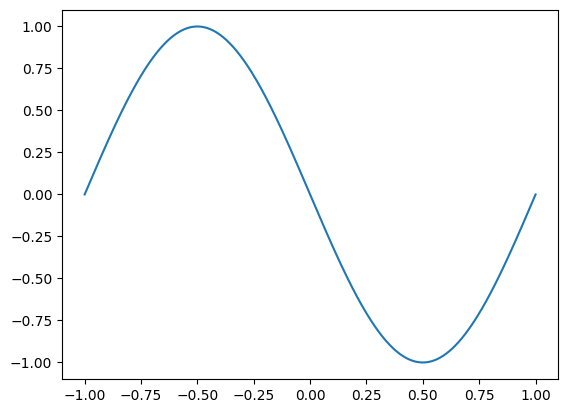

In [22]:
init_sample_size = 2000
x_ini = np.linspace(-1, 1, init_sample_size) # 初期条件のデータ: x
X_ini = np.zeros([init_sample_size, 2]) # 初期条件のデータ: (x, t) = (x, 0)
X_ini[:, 0] = x_ini
u_ini = -np.sin(np.pi * x_ini) # 初期条件のデータ: u(x, 0) = -sin(pi * x)
plt.plot(x_ini, u_ini)

X_ini_t = torch.tensor(X_ini, requires_grad=True, dtype=torch.float32).to(device) # 初期条件のデータをTensorに変換：shape = (init_sample_size, 2)
u_ini_t = torch.tensor(u_ini, requires_grad=True, dtype=torch.float32).to(device).unsqueeze(1) # 初期条件のデータをTensorに変換：shape = (init_sample_size, 1)

In [23]:
X_bc = np.zeros([2, 2]) # 境界条件のデータ: (x, t) = (-1, t)
X_bc[0, :] = [-1, 0]
X_bc[1, :] = [-1, 1]

bc_sample_size = 200
t_bc = np.linspace(0, 1, bc_sample_size) # 境界条件のデータ: t

X_bc1 = np.zeros([bc_sample_size, 2]) # 境界条件のデータ: (x, t) = (-1, t)
X_bc1[:, 0] = -1
X_bc1[:, 1] = t_bc

X_bc2 = np.zeros([bc_sample_size, 2]) # 境界条件のデータ: (x, t) = (1, t)
X_bc2[:, 0] = 1
X_bc2[:, 1] = t_bc

X_bc_stack = np.vstack([X_bc1, X_bc2]) # 境界条件のデータ: (x, t) = (-1, t) or (1, t)
u_bc_stack = np.zeros(X_bc_stack.shape[0]) # 境界条件のデータ: u(-1, t) = u(1, t) = 0

X_bc_t = torch.tensor(X_bc_stack, requires_grad=True, dtype=torch.float32).to(device) # 境界条件のデータをTensorに変換：shape = (2 * bc_sample_size, 2)
u_bc_t = torch.tensor(u_bc_stack, requires_grad=True, dtype=torch.float32).to(device).unsqueeze(1) # 境界条件のデータをTensorに変換：shape = (2 * bc_sample_size, 1)

In [24]:
# sampling points
x_ = np.linspace(-1, 1, 100)
t_ = np.linspace(0, 1, 100)

X, T = np.meshgrid(x_, t_, indexing="ij")
x_flat = X.flatten()
t_flat = T.flatten()

# sampling size
sample_size = 5000
random_idx = np.random.choice(np.arange(x_flat.shape[0]), sample_size, replace=False)

# sampling
x_sample = x_flat[random_idx]
t_sample = t_flat[random_idx]
X_sample = np.zeros([sample_size, 2])
X_sample[:, 0] = x_sample
X_sample[:, 1] = t_sample

X_sample_t = torch.tensor(X_sample, requires_grad=True, dtype=torch.float32).to(device)


3. MLPの構築

In [25]:
class PINN(torch.nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        self.activation = activation
        self.regressor = nn.Linear(5, 1)
        self.fc1 = self.linear(2, 5, activation=self.activation)
        self.fc2 = self.linear(5, 20, activation=self.activation)
        self.fc3 = self.linear(20, 40, activation=self.activation)
        self.fc4 = self.linear(40, 40, activation=self.activation)
        self.fc5 = self.linear(40, 40, activation=self.activation)
        self.fc6 = self.linear(40, 20, activation=self.activation)
        self.fc7 = self.linear(20, 10, activation=self.activation)
        self.fc8 = self.linear(10, 5, activation=self.activation)
    
    def linear(self, in_features, out_features, activation="relu"):
        layers  = [nn.Linear(in_features, out_features)]
        if activation == "relu":
            layers.append(nn.ReLU())
        elif activation == "tanh":
            layers.append(nn.Tanh())
        elif activation == "sigmoid":
            layers.append(nn.Sigmoid())
        else:
            pass
        return nn.Sequential(*layers)
    
    def forward(self, x, t):
        x = torch.cat([x, t], dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        x = self.regressor(x)
        return x

In [26]:
net = PINN(activation="tanh").to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [27]:
num_epoch = 10000

for epoch in range(num_epoch):
    optimizer.zero_grad()
    x_sampled = X_sample_t[:, 0].unsqueeze(-1).to(device)
    t_sampled = X_sample_t[:, 1].unsqueeze(-1).to(device)
    pin_loss = physics_informed_loss(x_sampled, t_sampled, net)

    x_ini = X_ini_t[:, 0].unsqueeze(-1).to(device)
    t_ini = X_ini_t[:, 1].unsqueeze(-1).to(device)
    ini_loss = initial_condition_loss(x_ini, t_ini, net, u_ini_t)

    x_bc = X_bc_t[:, 0].unsqueeze(-1).to(device)
    t_bc = X_bc_t[:, 1].unsqueeze(-1).to(device)
    bc_loss = boundary_condition_loss(x_bc, t_bc, net, u_bc_t)

    loss = pin_loss + ini_loss + bc_loss

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))
        pin_loss = pin_loss.item()
        ini_loss = ini_loss.item()
        bc_loss = bc_loss.item()
        print("pin_loss: {:.3f}, ini_loss: {:.3f}, bc_loss: {:.3f}".format(pin_loss, ini_loss, bc_loss))


epoch: 0, loss: 0.5644986629486084
pin_loss: 0.000, ini_loss: 0.531, bc_loss: 0.034
epoch: 100, loss: 0.38777849078178406
pin_loss: 0.010, ini_loss: 0.306, bc_loss: 0.072
epoch: 200, loss: 0.25594574213027954
pin_loss: 0.021, ini_loss: 0.189, bc_loss: 0.046
epoch: 300, loss: 0.18988136947155
pin_loss: 0.030, ini_loss: 0.129, bc_loss: 0.031
epoch: 400, loss: 0.10667684674263
pin_loss: 0.041, ini_loss: 0.062, bc_loss: 0.004
epoch: 500, loss: 0.0882519781589508
pin_loss: 0.036, ini_loss: 0.051, bc_loss: 0.001
epoch: 600, loss: 0.07457894086837769
pin_loss: 0.031, ini_loss: 0.043, bc_loss: 0.001
epoch: 700, loss: 0.04939189553260803
pin_loss: 0.022, ini_loss: 0.027, bc_loss: 0.000
epoch: 800, loss: 0.05639268830418587
pin_loss: 0.023, ini_loss: 0.032, bc_loss: 0.001
epoch: 900, loss: 0.04580579325556755
pin_loss: 0.019, ini_loss: 0.026, bc_loss: 0.000
epoch: 1000, loss: 0.035007886588573456
pin_loss: 0.015, ini_loss: 0.020, bc_loss: 0.000
epoch: 1100, loss: 0.028461840003728867
pin_loss: 0

In [28]:
X_test = np.zeros([x_flat.shape[0], 2])
X_test[:, 0] = x_flat
X_test[:, 1] = t_flat

X_test_t = torch.tensor(X_test).float().to(device)
x_test = X_test_t[:, 0].unsqueeze(dim=-1)
t_test = X_test_t[:, 1].unsqueeze(dim=-1)
u_pred = net(x_test, t_test)

In [29]:
u_pred_arr = u_pred.detach().cpu().numpy().reshape(100, 100)

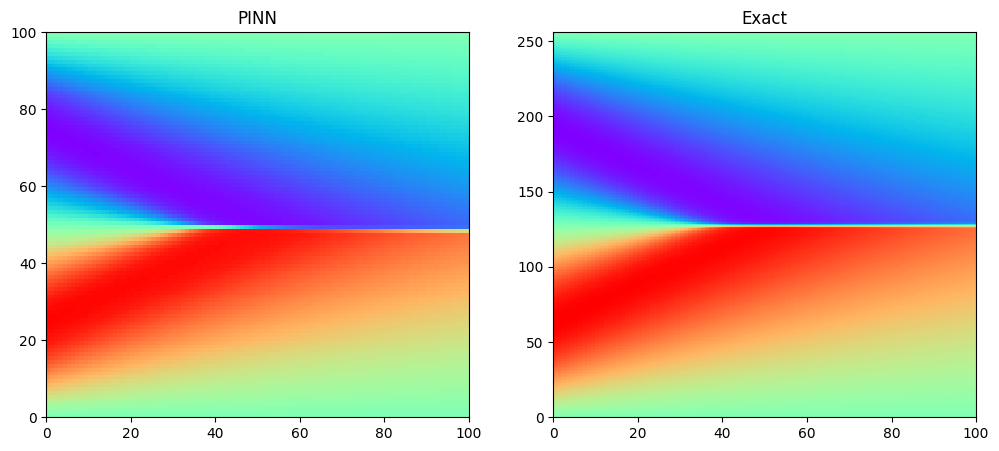

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('PINN')
plt.pcolor(u_pred_arr, cmap='rainbow', vmin=-1, vmax=1)
plt.subplot(1, 2, 2)
plt.title('Exact')
plt.pcolor(u_exact, cmap='rainbow', vmin=-1, vmax=1)